In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

import os
import numpy as np
import pandas as pd
import math
import cv2
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,Concatenate,Add,Dropout,ReLU,Conv2DTranspose,UpSampling2D



2022-12-04 10:34:43.189212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 10:34:43.308103: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user2/anaconda3/envs/tf/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-10.2/lib64
2022-12-04 10:34:43.308123: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-04 10:34:44.240727: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

## Model 

In [34]:
class SimpleMLP2:
    @staticmethod
    def build():
        inputs = tf.keras.Input(shape=(image_size,image_size,1),name='input')
        #inputs = keras.Input(shape=(128, 128, 1))
        x = tf.keras.layers.Reshape((1, 448, 448, 1), input_shape=(None, 1, 448, 448 ,1))
        #flat = keras.layers.Flatten()(x)

        layer_0 = Conv2D(64,(7,7),strides=(2,2),padding='same',name='input_conv1',activation=None)(inputs)
        layer = BatchNormalization(name='input_conv1bn')(layer_0)
        layer = ReLU(name='input_conv1relu')(layer)

        ## Encoder
        layer = resblock(layer,'en_l1',64,keep_scale,l1l2,downsample=True,bn_act=True,first_layer=True)
        layer = resblock(layer,'en_l2',64,keep_scale,l1l2,downsample=False,bn_act=True)
        encoder_1 = resblock(layer,'en_l3',64,keep_scale,l1l2,downsample=False,bn_act=False)
        layer = BatchNormalization(name='en_l3_finalbn')(encoder_1)
        layer = ReLU(name='en_l3_finalrelu')(layer)

        layer = resblock(layer,'en_l4',128,keep_scale,l1l2,downsample=True,bn_act=True)
        layer = resblock(layer,'en_l5',128,keep_scale,l1l2,downsample=False,bn_act=True)
        layer = resblock(layer,'en_l6',128,keep_scale,l1l2,downsample=False,bn_act=True)
        encoder_2 = resblock(layer,'en_l7',128,keep_scale,l1l2,downsample=False,bn_act=False)
        layer = BatchNormalization(name='en_l7_finalbn')(encoder_2)
        layer = ReLU(name='en_l7_finalrelu')(layer)

        layer = resblock(layer,'en_l8',256,keep_scale,l1l2,downsample=True,bn_act=True)
        layer = resblock(layer,'en_l9',256,keep_scale,l1l2,downsample=False,bn_act=True)
        layer = resblock(layer,'en_l10',256,keep_scale,l1l2,downsample=False,bn_act=True)
        layer = resblock(layer,'en_l11',256,keep_scale,l1l2,downsample=False,bn_act=True)
        layer = resblock(layer,'en_l12',256,keep_scale,l1l2,downsample=False,bn_act=True)
        encoder_3 = resblock(layer,'en_l13',256,keep_scale,l1l2,downsample=False,bn_act=False)
        layer = BatchNormalization(name='en_l13_finalbn')(encoder_3)
        layer = ReLU(name='en_l13_finalrelu')(layer)

        layer = resblock(layer,'en_l14',512,keep_scale,l1l2,downsample=True,bn_act=True)
        layer = resblock(layer,'en_l15',512,keep_scale,l1l2,downsample=False,bn_act=True)
        layer = resblock(layer,'en_l16',512,keep_scale,l1l2,downsample=False,bn_act=True)

        ## DAC block
        b1 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b1_conv1',activation=None)(layer)
        # b1 = BatchNormalization()(b1)
        # b1 = ReLU(name='dac_b1_relu')(b1)

        b2 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b2_conv1',activation=None)(layer)
        b2 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b2_conv2',activation=None)(b2)
        # b2 = BatchNormalization()(b2)
        # b2 = ReLU(name='dac_b2_relu')(b2)

        b3 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b3_conv1',activation=None)(layer)
        b3 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b3_conv2',activation=None)(b3)
        b3 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b3_conv3',activation=None)(b3)
        # b3 = BatchNormalization()(b3)
        # b3 = ReLU(name='dac_b3_relu')(b3)

        b4 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b4_conv1',activation=None)(layer)
        b4 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b4_conv2',activation=None)(b4)
        b4 = Conv2D(512,(3,3),padding='same',dilation_rate=5,name='dac_b4_conv3',activation=None)(b4)
        b4 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b4_conv4',activation=None)(b4)
        # b4 = BatchNormalization()(b4)
        # b4 = ReLU(name='dac_b4_relu')(b4)

        layer = Add(name='dac_add')([layer,b1,b2,b3,b4])
        # layer = BatchNormalization(name='dac_bn')(layer)
        layer = ReLU(name='dac_relu')(layer)

        ## RMP block
        b1 = MaxPool2D((2,2),strides=(2,2),padding='valid',name='rmp_b1_pool')(layer)
        b1 = Conv2D(1,(1,1),padding='valid',name='rmb_b1_conv1',activation=None)(b1)
        b1 = Conv2DTranspose(1,(1,1),(2,2),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b1)
        b1 = tf.image.resize(b1, [14,14], method=tf.image.ResizeMethod.BILINEAR)

        b2 = MaxPool2D((3,3),strides=(3,3),padding='valid',name='rmp_b2_pool')(layer)
        b2 = Conv2D(1,(1,1),padding='valid',name='rmb_b2_conv1',activation=None)(b2)
        b2 = Conv2DTranspose(1,(1,1),(3,3),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b2)
        b2 = tf.image.resize(b2, [14,14], method=tf.image.ResizeMethod.BILINEAR)

        b3 = MaxPool2D((5,5),strides=(5,5),padding='valid',name='rmp_b3_pool')(layer)
        b3 = Conv2D(1,(1,1),padding='valid',name='rmb_b3_conv1',activation=None)(b3)
        b3 = Conv2DTranspose(1,(1,1),(5,5),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b3)
        b3 = tf.image.resize(b3, [14,14], method=tf.image.ResizeMethod.BILINEAR)

        b4 = MaxPool2D((6,6),strides=(6,6),padding='valid',name='rmp_b4_pool')(layer)
        b4 = Conv2D(1,(1,1),padding='valid',name='rmb_b4_conv1',activation=None)(b4)
        b4 = Conv2DTranspose(1,(1,1),(6,6),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b4)
        b4 = tf.image.resize(b4, [14,14], method=tf.image.ResizeMethod.BILINEAR)

        layer = Concatenate(name='rmp_concat')([layer,b1,b2,b3,b4])
        layer = ReLU(name='rmp_relu')(layer)

        layer = Conv2D(256,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l1_conv1',activation=None)(layer)
        layer = BatchNormalization(name='de_l1_conv1bn')(layer)
        layer = ReLU(name='de_l1_conv1relu')(layer)
        layer = Conv2DTranspose(256,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l1_deconv2',activation=None)(layer)
        layer = BatchNormalization(name='de_l1_conv2bn')(layer)
        layer = ReLU(name='de_l1_deconv2relu')(layer)
        layer = Conv2D(256,(3,3),padding='same',kernel_regularizer=l1l2,name='de_l1_conv3',activation=None)(layer)
        layer = Add(name='de_l1_add')([encoder_3*keep_scale,layer*(1-keep_scale)])
        layer = BatchNormalization(name='de_l1_conv3bn')(layer)
        layer = ReLU(name='de_l1_conv3relu')(layer)

        layer = Conv2D(128,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l2_conv1',activation=None)(layer)
        layer = BatchNormalization(name='de_l2_conv1bn')(layer)
        layer = ReLU(name='de_l2_conv1relu')(layer)
        layer = Conv2DTranspose(128,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l2_deconv2',activation=None)(layer)
        layer = BatchNormalization(name='de_l2_conv2bn')(layer)
        layer = ReLU(name='de_l2_deconv2relu')(layer)
        layer = Conv2D(128,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l2_conv3',activation=None)(layer)
        layer = Add(name='de_l2_add')([encoder_2*keep_scale,layer*(1-keep_scale)])
        layer = BatchNormalization(name='de_l2_conv3bn')(layer)
        layer = ReLU(name='de_l2_conv3relu')(layer)

        layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l3_conv1',activation=None)(layer)
        layer = BatchNormalization(name='de_l3_conv1bn')(layer)
        layer = ReLU(name='de_l3_conv1relu')(layer)
        layer = Conv2DTranspose(64,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l3_deconv2',activation=None)(layer)
        layer = BatchNormalization(name='de_l3_conv2bn')(layer)
        layer = ReLU(name='de_l3_deconv2relu')(layer)
        layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l3_conv3',activation=None)(layer)
        layer = Add(name='de_l3_add')([encoder_1*keep_scale,layer*(1-keep_scale)])
        layer = BatchNormalization(name='de_l3_conv3bn')(layer)
        layer = ReLU(name='de_l3_conv3relu')(layer)

        layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l4_conv1',activation=None)(layer)
        layer = BatchNormalization(name='de_l4_conv1bn')(layer)
        layer = ReLU(name='de_l4_conv1relu')(layer)
        layer = Conv2DTranspose(64,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l4_deconv2',activation=None)(layer)
        layer = BatchNormalization(name='de_l4_conv2bn')(layer)
        layer = ReLU(name='de_l4_deconv2relu')(layer)
        layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l4_conv3',activation=None)(layer)
        layer = Add(name='de_l4_add')([layer_0*keep_scale,layer*(1-keep_scale)])
        layer = BatchNormalization(name='de_l4_conv3bn')(layer)
        layer = ReLU(name='de_l4_conv3relu')(layer)

        layer = Conv2DTranspose(32,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name='final_deconv1',activation=None)(layer)
        layer = BatchNormalization()(layer)
        layer = ReLU()(layer)
        layer = Conv2D(32,(3,3),padding='same',kernel_regularizer=l1l2,name='final_conv1',activation=None)(layer)
        layer = BatchNormalization()(layer)
        layer = ReLU()(layer)
        outputs = Conv2D(1,(3,3),padding='same',name='output',activation=None)(layer)

        model = tf.keras.Model(inputs,outputs,name='CE-Net')
        #model.summary()
        
        return model

In [38]:
keep_scale = 0.2
l1l2 = tf.keras.regularizers.l1_l2(l1=0, l2=0.0005)

def resblock(x,level='en_l1',filters=64,keep_scale=keep_scale,l1l2=l1l2,downsample=False,bn_act=True,first_layer=False):
    if downsample:
        if not first_layer:
            x_H = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_Hconv')(x)
            x = Conv2D(filters/2,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
        else:
            x_H = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_Hconv')(x)
            x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
    else:
        x_H = x
        x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
    x = BatchNormalization(name=level+'_conv1bn')(x)
    x = ReLU(name=level+'_conv1relu')(x)
    if downsample:
        x = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_conv2')(x)
    else:
        x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv2')(x)
    x = BatchNormalization(name=level+'_conv2bn')(x)
    x = ReLU(name=level+'_conv2relu')(x)
    x = Add(name=level+'_add')([x_H*keep_scale,x*(1-keep_scale)])
    if bn_act:
        x = BatchNormalization(name=level+'_finalbn')(x)
        x = ReLU(name=level+'_finalrelu')(x)       
    return x

[0.0001, 9.909954834128343e-05, 9.819818665965754e-05, 9.729590473501306e-05, 9.63926921258551e-05, 9.548853816214998e-05, 9.458343193786322e-05, 9.367736230317176e-05, 9.277031785633283e-05, 9.186228693518995e-05, 9.095325760829622e-05, 9.004321766563289e-05, 8.91321546089e-05, 8.822005564135439e-05, 8.73069076571686e-05, 8.639269723028191e-05, 8.547741060271343e-05, 8.45610336723042e-05, 8.36435519798534e-05, 8.272495069561094e-05, 8.180521460508584e-05, 8.088432809412662e-05, 7.996227513322693e-05, 7.903903926100555e-05, 7.811460356680608e-05, 7.718895067235705e-05, 7.626206271242883e-05, 7.533392131441787e-05, 7.440450757678327e-05, 7.347380204625457e-05]


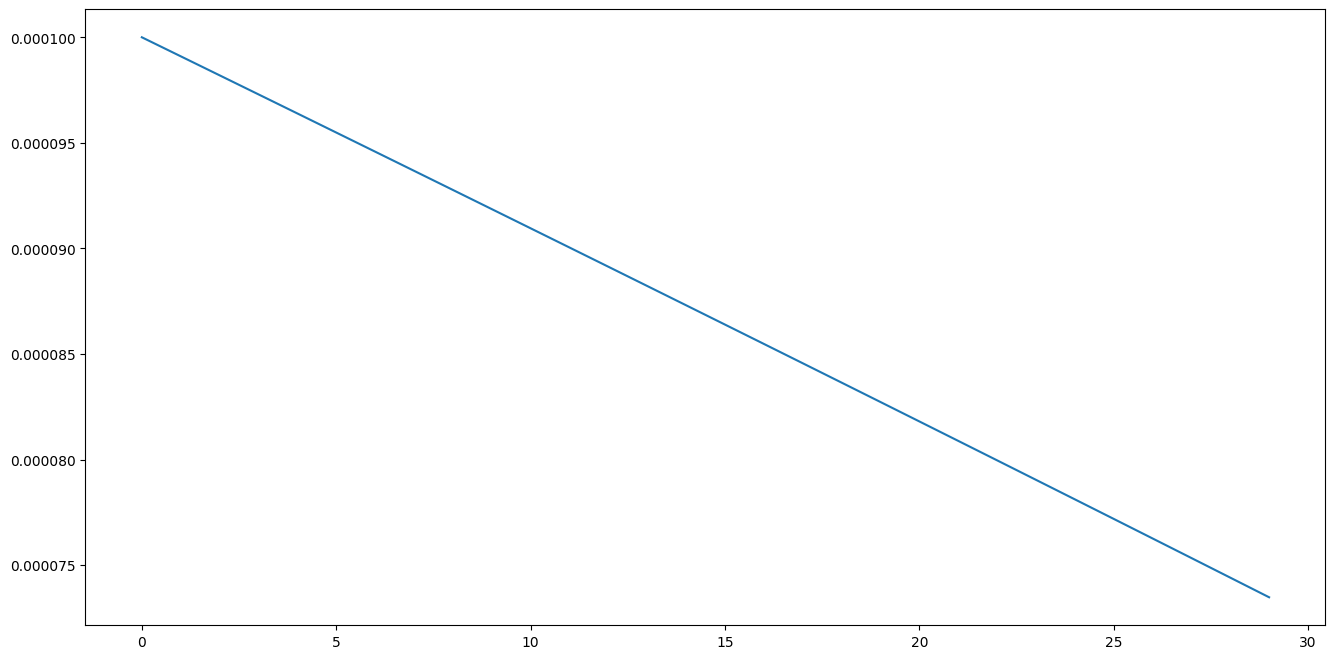

In [84]:
lr_init = 0.0001

def scheduler_1(epoch):
    epoch += 1

    if epoch <= 4:
        return lr_init    

    if epoch >= 5 and epoch <= 10:
        return lr_init-lr_init*math.exp(0.25*(epoch-8))/40

    elif epoch >= 11 and epoch <= 50:
        return lr_init*math.exp(-0.05*(epoch-10))

    else:
        return scheduler_1(50-1)

def scheduler_2(epoch):  
    epoch += 1

    if epoch == 1:
        return lr_init

    elif epoch >= 2 and epoch <= 35:
        return (0.25*epoch**3)*math.exp(-0.25*epoch)*lr_init

    else:
        return scheduler_2(35-1)
def scheduler_3(epoch):

    if epoch == 0:
        return lr_init

    else:
        return lr_init*((1-epoch/100)**0.9)

stage = [i for i in range(0,30)]
lr_plot = [scheduler_3(x) for x in stage]
plt.plot(stage, lr_plot)
print(lr_plot)

smooth = K.epsilon()
threshold = 0.8
label_smoothing = 0.0
bce_weight = 0.5

def dice_coeff(y_true, y_pred):
    numerator = tf.math.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + smooth
    return tf.math.reduce_mean(2.* numerator / denominator) * 448 * 448

def dice_loss(y_true, y_pred):
    return - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return bce_weight * tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=label_smoothing) - dice_coeff(y_true, y_pred) 

def bce_dice_loss_try(y_true, y_pred):
    x = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=label_smoothing)
    y = -dice_coeff(y_true, y_pred)
    return x + x/(x+y)*y

def iou(y_true, y_pred):
    overlap = tf.math.logical_and((y_true > threshold),(y_pred > threshold))
    union = tf.math.logical_or((y_true > threshold),(y_pred > threshold))
    iou = (tf.cast(tf.math.count_nonzero(overlap),tf.float32) + smooth) / (tf.cast(tf.math.count_nonzero(union),tf.float32) + smooth)
    return iou



In [47]:
image_path = '/home/user2/Desktop/rumi/mri segmentation/2d_images'
mask_path = '/home/user2/Desktop/rumi/mri segmentation/2d_masks'

In [80]:
autotune = tf.data.experimental.AUTOTUNE
image_size = 448
batch_size = 10

In [81]:
exclude = [image_path+'/ID_0254_Z_0075.tif',mask_path+'/ID_0254_Z_0075.tif',
           image_path+'/ID_0052_Z_0108.tif',mask_path+'/ID_0052_Z_0108.tif',
           image_path+'/ID_0079_Z_0072.tif',mask_path+'/ID_0079_Z_0072.tif',
           image_path+'/ID_0134_Z_0137.tif',mask_path+'/ID_0134_Z_0137.tif']
num_files = 50

def read_image(image):
    path = image.numpy().decode('utf-8')
    if path not in exclude:
        image = cv2.imread(path,0)
        image = np.expand_dims(image,2)
        image = tf.image.resize(image, [image_size,image_size])
    else:
        image = np.zeros((image_size,image_size,1),dtype=np.float32)
    return image

def read_mask(image):
    path = image.numpy().decode('utf-8')
    if path not in exclude:
        image = cv2.imread(path,0)
        image = image*257.
        image = np.expand_dims(image,2)
        image = tf.image.resize(image, [image_size,image_size])
    else:
        image = np.zeros((image_size,image_size,1),dtype=np.float32)
    return image

def aug(image,label):
    seed = np.random.randint(0,64)
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    image = tf.image.random_contrast(image, 0.3, 0.7, seed=seed)
    label = tf.image.random_flip_left_right(label, seed=seed)
    label = tf.image.random_flip_up_down(label, seed=seed)
    label = tf.image.random_contrast(label, 0.3, 0.7, seed=seed)
    return image,label


50


#  Loading dataset

In [73]:
num_files=50

In [105]:

dataset_image1 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_images/client1/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_image,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)
dataset_mask1 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_masks/client1/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)

dataset_image2 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_images/client2/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_image,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)
dataset_mask2 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_masks/client2/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)

dataset_image3 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_images/client3/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_image,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)
dataset_mask3 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_masks/client3/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)

dataset_image4 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_images/client4/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_image,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)
dataset_mask4 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_masks/client4/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)

dataset_image5 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_images/client5/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_image,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)
dataset_mask5 = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation2/2d_masks/client5/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)


In [82]:
dataset1 = tf.data.Dataset.zip((dataset_image1, dataset_mask1))
dataset1 = dataset1.repeat().shuffle(21).batch(batch_size).cache().prefetch(autotune)
train1 = dataset1.take(int(0.8*num_files//batch_size))
test1 = dataset1.skip(int(0.8*num_files//batch_size))

In [106]:
dataset2 = tf.data.Dataset.zip((dataset_image2, dataset_mask2))
dataset2 = dataset2.repeat().shuffle(21).batch(batch_size).cache().prefetch(autotune)
train2 = dataset2.take(int(0.8*num_files//batch_size))
test2 = dataset2.skip(int(0.8*num_files//batch_size))

In [107]:
dataset3 = tf.data.Dataset.zip((dataset_image3, dataset_mask3))
dataset3 = dataset3.repeat().shuffle(21).batch(batch_size).cache().prefetch(autotune)
train3 = dataset3.take(int(0.8*num_files//batch_size))
test3 = dataset3.skip(int(0.8*num_files//batch_size))


In [108]:
dataset4 = tf.data.Dataset.zip((dataset_image4, dataset_mask4))
dataset4 = dataset4.repeat().shuffle(21).batch(batch_size).cache().prefetch(autotune)
train4 = dataset4.take(int(0.8*num_files//batch_size))
test4 = dataset4.skip(int(0.8*num_files//batch_size))


In [109]:
dataset5 = tf.data.Dataset.zip((dataset_image5, dataset_mask5))
dataset5 = dataset5.repeat().shuffle(21).batch(batch_size).cache().prefetch(autotune)
train5 = dataset5.take(int(0.8*num_files//batch_size))
test5 = dataset5.skip(int(0.8*num_files//batch_size))


In [127]:
trains=[train1, train2, train3, train4, train5]
tests=[test1, test2, test3, test4, test5]

#trains=[train1]
#tests=[test1]

# Model initialization and training

In [128]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [129]:
loss = bce_dice_loss
optimizer = tf.keras.optimizers.Adam(lr_init)
metrics = [tf.keras.metrics.BinaryCrossentropy(from_logits=False,label_smoothing=label_smoothing,dtype=tf.float32,name='bce'), dice_coeff, iou]


In [130]:
SCALINGFACTOR=0.2
EPOCH=5
smlp_SGD2 = SimpleMLP2()
SGD_model2 = smlp_SGD2.build() 
SGD_model2.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

In [132]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()


    #loop through each client and create new local model
    for i in range(5):
        print("for client ", i)
        smlp_local = SimpleMLP2()
        local_model = smlp_local.build()
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        
        SGD_model2.fit(trains[i], batch_size=batch_size, epochs=EPOCH, callbacks=[scheduler,earlystop,checkpoint],
            validation_data=tests[i], steps_per_epoch=int(0.8*num_files//batch_size), validation_steps=int(0.2*num_files//batch_size), shuffle=True)
        
        #scale the model weights and add to list
        scaling_factor = SCALINGFACTOR
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)


for client  0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: 221915.9375 - bce: 157458.8125 - dice_coeff: -143181.7656 - iou: 0.0271

2022-12-04 18:46:16.402070: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 88s 17s/step - loss: 208039.9531 - bce: 148589.1406 - dice_coeff: -133740.5938 - iou: 0.0263 - val_loss: 136436.4844 - val_bce: 87663.8906 - val_dice_coeff: -92599.8594 - val_iou: 0.1386 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 18:46:36.953350: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 14s - loss: 160510.4688 - bce: 127091.4375 - dice_coeff: -96960.1797 - iou: 0.0295 

2022-12-04 18:47:22.244819: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 64s 16s/step - loss: 157193.5781 - bce: 129124.8672 - dice_coeff: -92626.5312 - iou: 0.0301 - val_loss: 64135.8359 - val_bce: 86830.4297 - val_dice_coeff: -20716.0293 - val_iou: 0.1466 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 18:47:40.865596: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 14s - loss: 92282.2578 - bce: 112834.8438 - dice_coeff: -35860.2305 - iou: 0.0267 

2022-12-04 18:48:25.966703: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 63s 16s/step - loss: 105552.8359 - bce: 112222.7031 - dice_coeff: -49436.8555 - iou: 0.0317 - val_loss: 30281.5371 - val_bce: 60861.0938 - val_dice_coeff: 153.6343 - val_iou: 0.1412 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 18:48:44.430808: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 14s - loss: 58884.3008 - bce: 92516.3125 - dice_coeff: -12621.4990 - iou: 0.0683

2022-12-04 18:49:29.487671: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 64s 16s/step - loss: 63299.8047 - bce: 93792.0000 - dice_coeff: -16399.1680 - iou: 0.0727 - val_loss: 11484.9092 - val_bce: 62925.6328 - val_dice_coeff: 19982.5332 - val_iou: 0.1305 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 18:49:47.997781: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 14s - loss: 18557.5879 - bce: 80957.9297 - dice_coeff: 21926.0176 - iou: 0.1175

2022-12-04 18:50:32.903414: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 64s 16s/step - loss: 2730.2695 - bce: 73229.4375 - dice_coeff: 33889.1016 - iou: 0.1235 - val_loss: -28833.9883 - val_bce: 56008.7695 - val_dice_coeff: 56842.9961 - val_iou: 0.1395 - lr: 9.6393e-05


2022-12-04 18:50:51.814279: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  1

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -37784.9531 - bce: 51609.9766 - dice_coeff: 63594.5781 - iou: 0.1490

2022-12-04 18:51:44.754358: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 71s 17s/step - loss: -35498.2734 - bce: 49708.0664 - dice_coeff: 60356.9453 - iou: 0.1537 - val_loss: -102392.0000 - val_bce: 27826.8770 - val_dice_coeff: 116310.0547 - val_iou: 0.1468 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 18:52:04.312605: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 14s - loss: -67569.6641 - bce: 33180.1055 - dice_coeff: 84164.3906 - iou: 0.1948

2022-12-04 18:52:49.789636: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 64s 16s/step - loss: -71520.0859 - bce: 28391.7773 - dice_coeff: 85720.6406 - iou: 0.1954 - val_loss: -129991.7656 - val_bce: 30221.9492 - val_dice_coeff: 145107.2656 - val_iou: 0.1400 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 18:53:08.328849: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 16s - loss: -129867.2500 - bce: -15691.7295 - dice_coeff: 122025.9609 - iou: 0.1950

2022-12-04 18:53:56.022967: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 70s 18s/step - loss: -147549.2031 - bce: -20709.7910 - dice_coeff: 137198.9688 - iou: 0.2002 - val_loss: -145892.5469 - val_bce: 39675.1680 - val_dice_coeff: 165734.7500 - val_iou: 0.1390 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 18:54:18.352369: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -197153.7969 - bce: -40079.1992 - dice_coeff: 177118.9375 - iou: 0.2160

2022-12-04 18:55:05.792316: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -201323.7344 - bce: -40943.2422 - dice_coeff: 180856.7812 - iou: 0.2208 - val_loss: -179760.5312 - val_bce: 41326.0820 - val_dice_coeff: 200428.2500 - val_iou: 0.1441 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 18:55:25.372011: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -204779.5000 - bce: -41146.8633 - dice_coeff: 184210.7500 - iou: 0.2351

2022-12-04 18:56:13.425490: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - ETA: 0s - loss: -218341.8281 - bce: -44560.1055 - dice_coeff: 196066.4688 - iou: 0.2354 

2022-12-04 18:56:33.155550: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 69s 18s/step - loss: -218341.8281 - bce: -44560.1055 - dice_coeff: 196066.4688 - iou: 0.2354 - val_loss: -226178.9688 - val_bce: 32025.5566 - val_dice_coeff: 242196.5938 - val_iou: 0.1433 - lr: 9.6393e-05
for client  2

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 16s - loss: -234323.1719 - bce: -55480.0820 - dice_coeff: 206587.6406 - iou: 0.2278

2022-12-04 18:57:31.696134: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 75s 18s/step - loss: -247300.3281 - bce: -66196.9141 - dice_coeff: 214206.3125 - iou: 0.2456 - val_loss: -282811.0938 - val_bce: 18759.8770 - val_dice_coeff: 292195.3125 - val_iou: 0.2040 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 18:57:51.539378: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -261220.1719 - bce: -77195.0391 - dice_coeff: 222627.1719 - iou: 0.2479

2022-12-04 18:58:38.279525: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -273417.3125 - bce: -79660.7031 - dice_coeff: 233591.4688 - iou: 0.2448 - val_loss: -338215.2812 - val_bce: -40017.5352 - val_dice_coeff: 318211.2500 - val_iou: 0.1752 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 18:58:57.570883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -345272.0938 - bce: -109489.9609 - dice_coeff: 290531.3438 - iou: 0.2534

2022-12-04 18:59:43.857727: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -380184.0000 - bce: -124727.7891 - dice_coeff: 317824.3438 - iou: 0.2683 - val_loss: -351159.7500 - val_bce: -43031.8789 - val_dice_coeff: 329648.7812 - val_iou: 0.2061 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:00:02.822385: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -396657.4375 - bce: -130768.6328 - dice_coeff: 331277.9062 - iou: 0.2672

2022-12-04 19:00:49.579271: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -399949.0625 - bce: -128397.7500 - dice_coeff: 335755.0312 - iou: 0.2606 - val_loss: -427057.6875 - val_bce: -56813.7383 - val_dice_coeff: 398654.8750 - val_iou: 0.1995 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:01:08.536312: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -436387.1250 - bce: -137039.1250 - dice_coeff: 367872.6250 - iou: 0.2731

2022-12-04 19:01:54.894820: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -448275.4062 - bce: -141354.6875 - dice_coeff: 377603.1562 - iou: 0.2741 - val_loss: -573258.3125 - val_bce: -104699.3984 - val_dice_coeff: 520913.6875 - val_iou: 0.2880 - lr: 9.6393e-05


2022-12-04 19:02:13.914126: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  3

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -441970.5938 - bce: -117699.5234 - dice_coeff: 383125.8438 - iou: 0.2297

2022-12-04 19:03:09.861782: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 75s 17s/step - loss: -412155.9375 - bce: -111296.0781 - dice_coeff: 356512.7812 - iou: 0.2224 - val_loss: -573438.6250 - val_bce: -122500.0625 - val_dice_coeff: 512193.8438 - val_iou: 0.2068 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:03:30.728876: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -427713.7188 - bce: -120406.5078 - dice_coeff: 367515.2188 - iou: 0.2407

2022-12-04 19:04:17.754098: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -434826.3438 - bce: -117074.4688 - dice_coeff: 376293.6250 - iou: 0.2297 - val_loss: -579598.8125 - val_bce: -121801.3047 - val_dice_coeff: 518702.1250 - val_iou: 0.2099 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:04:37.062847: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 16s - loss: -460964.0625 - bce: -119656.7109 - dice_coeff: 401140.1250 - iou: 0.2319

2022-12-04 19:05:25.056742: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 68s 17s/step - loss: -447229.1562 - bce: -116469.8125 - dice_coeff: 388998.5312 - iou: 0.2287 - val_loss: -647519.0625 - val_bce: -148905.5938 - val_dice_coeff: 573070.6250 - val_iou: 0.2380 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:05:44.697270: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -555377.8750 - bce: -138791.9062 - dice_coeff: 485986.3750 - iou: 0.2457

2022-12-04 19:06:31.978251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -556381.6875 - bce: -136244.7500 - dice_coeff: 488263.9375 - iou: 0.2415 - val_loss: -596781.6875 - val_bce: -110876.0156 - val_dice_coeff: 541347.6250 - val_iou: 0.1863 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:06:51.360776: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -483100.1875 - bce: -114841.3281 - dice_coeff: 425683.7188 - iou: 0.2226

2022-12-04 19:07:38.974191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -523287.6875 - bce: -121958.1250 - dice_coeff: 462313.1250 - iou: 0.2238 - val_loss: -729775.3125 - val_bce: -142618.6250 - val_dice_coeff: 658469.6875 - val_iou: 0.2154 - lr: 9.6393e-05


2022-12-04 19:07:58.335576: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  4

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -616008.6875 - bce: -150927.4375 - dice_coeff: 540549.5000 - iou: 0.2712

2022-12-04 19:08:53.438832: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -603100.8750 - bce: -143376.6875 - dice_coeff: 531417.0625 - iou: 0.2584 - val_loss: -831944.0000 - val_bce: -197780.8594 - val_dice_coeff: 733057.5625 - val_iou: 0.2816 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:09:13.373961: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -651111.8750 - bce: -145699.4219 - dice_coeff: 578267.0625 - iou: 0.2569

2022-12-04 19:10:00.154779: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 16s/step - loss: -643290.9375 - bce: -137466.7031 - dice_coeff: 574562.6250 - iou: 0.2422 - val_loss: -789287.6250 - val_bce: -138066.8281 - val_dice_coeff: 720259.3750 - val_iou: 0.2194 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:10:19.167541: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -801248.0000 - bce: -168982.9062 - dice_coeff: 716761.3125 - iou: 0.2746

2022-12-04 19:11:05.630572: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -779352.5625 - bce: -164012.6562 - dice_coeff: 697350.9375 - iou: 0.2736 - val_loss: -863096.1250 - val_bce: -175372.5000 - val_dice_coeff: 775413.6875 - val_iou: 0.2538 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:11:24.783135: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -778006.5625 - bce: -158487.9688 - dice_coeff: 698767.1875 - iou: 0.2679

2022-12-04 19:12:11.103671: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -780529.1250 - bce: -151817.8906 - dice_coeff: 704624.6250 - iou: 0.2566 - val_loss: -902529.3750 - val_bce: -188433.3438 - val_dice_coeff: 808318.7500 - val_iou: 0.2753 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:12:30.200809: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -859307.3750 - bce: -154553.2500 - dice_coeff: 782034.7500 - iou: 0.2560

2022-12-04 19:13:16.795612: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -851054.0000 - bce: -153081.4062 - dice_coeff: 774517.5000 - iou: 0.2547 - val_loss: -994940.1250 - val_bce: -195848.2188 - val_dice_coeff: 897021.5625 - val_iou: 0.2758 - lr: 9.6393e-05


2022-12-04 19:13:36.293813: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -973541.9375 - bce: -177623.2969 - dice_coeff: 884735.3125 - iou: 0.2841

2022-12-04 19:14:47.420798: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -994282.1875 - bce: -178112.9844 - dice_coeff: 905230.7500 - iou: 0.2842 - val_loss: -1009908.1250 - val_bce: -206787.6250 - val_dice_coeff: 906518.7500 - val_iou: 0.2770 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:15:07.535532: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1015131.7500 - bce: -164516.8281 - dice_coeff: 932878.1875 - iou: 0.2744

2022-12-04 19:15:54.811935: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -989473.8125 - bce: -160256.9219 - dice_coeff: 909350.4375 - iou: 0.2701 - val_loss: -944756.8750 - val_bce: -177336.3281 - val_dice_coeff: 856095.5625 - val_iou: 0.2505 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:16:14.755713: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1064423.1250 - bce: -167107.7656 - dice_coeff: 980873.8125 - iou: 0.2843

2022-12-04 19:17:01.270500: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -1091407.6250 - bce: -165418.7969 - dice_coeff: 1008702.6875 - iou: 0.2884 - val_loss: -1029449.8750 - val_bce: -172932.9375 - val_dice_coeff: 942989.3750 - val_iou: 0.2294 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:17:20.369656: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1190730.3750 - bce: -175496.6562 - dice_coeff: 1102986.6250 - iou: 0.3452

2022-12-04 19:18:06.439068: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -1200309.3750 - bce: -177698.6875 - dice_coeff: 1111464.7500 - iou: 0.3540 - val_loss: -1098621.2500 - val_bce: -165086.4375 - val_dice_coeff: 1016080.5625 - val_iou: 0.2142 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:18:25.694136: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1206001.3750 - bce: -167281.5938 - dice_coeff: 1122364.0000 - iou: 0.3641

2022-12-04 19:19:12.344029: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -1226562.3750 - bce: -163385.2031 - dice_coeff: 1144873.2500 - iou: 0.3712 - val_loss: -1107690.5000 - val_bce: -197107.0156 - val_dice_coeff: 1009140.3750 - val_iou: 0.2504 - lr: 9.6393e-05


2022-12-04 19:19:31.459529: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  1

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -1318737.3750 - bce: -175890.6094 - dice_coeff: 1230795.8750 - iou: 0.4560

2022-12-04 19:20:25.867212: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -1319550.7500 - bce: -174590.3750 - dice_coeff: 1232260.0000 - iou: 0.4533 - val_loss: -1057565.6250 - val_bce: -212211.3594 - val_dice_coeff: 951465.2500 - val_iou: 0.2698 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:20:45.890266: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1432370.0000 - bce: -173171.7031 - dice_coeff: 1345788.5000 - iou: 0.4706

2022-12-04 19:21:32.931853: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -1443481.2500 - bce: -176006.1094 - dice_coeff: 1355482.6250 - iou: 0.4769 - val_loss: -1108305.0000 - val_bce: -195332.4688 - val_dice_coeff: 1010642.8125 - val_iou: 0.2508 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:21:53.380873: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1490391.7500 - bce: -180446.7656 - dice_coeff: 1400175.3750 - iou: 0.4910

2022-12-04 19:22:41.203883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -1500260.7500 - bce: -184054.2656 - dice_coeff: 1408239.6250 - iou: 0.4981 - val_loss: -1011897.1875 - val_bce: -220610.1250 - val_dice_coeff: 901598.1875 - val_iou: 0.2852 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:23:00.632785: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1594099.7500 - bce: -175509.0781 - dice_coeff: 1506349.3750 - iou: 0.4792

2022-12-04 19:23:47.756617: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -1586317.5000 - bce: -174926.0781 - dice_coeff: 1498859.0000 - iou: 0.4788 - val_loss: -1102486.7500 - val_bce: -217660.9844 - val_dice_coeff: 993662.9375 - val_iou: 0.2726 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:24:06.817214: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1740754.1250 - bce: -182009.4219 - dice_coeff: 1649754.5000 - iou: 0.5016

2022-12-04 19:24:53.131242: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -1736515.6250 - bce: -182202.6562 - dice_coeff: 1645418.5000 - iou: 0.5014 - val_loss: -1207821.3750 - val_bce: -228556.3906 - val_dice_coeff: 1093550.2500 - val_iou: 0.2776 - lr: 9.6393e-05


2022-12-04 19:25:12.124293: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  2

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -1782218.8750 - bce: -186712.5156 - dice_coeff: 1688866.3750 - iou: 0.5201

2022-12-04 19:26:06.555209: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -1788248.3750 - bce: -185219.7188 - dice_coeff: 1695642.2500 - iou: 0.5203 - val_loss: -1160269.8750 - val_bce: -217940.4688 - val_dice_coeff: 1051304.7500 - val_iou: 0.2667 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:26:26.707510: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1891072.1250 - bce: -180203.4688 - dice_coeff: 1800974.6250 - iou: 0.5130

2022-12-04 19:27:13.136620: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -1897448.0000 - bce: -182963.3594 - dice_coeff: 1805969.5000 - iou: 0.5193 - val_loss: -1173818.3750 - val_bce: -214695.5469 - val_dice_coeff: 1066476.8750 - val_iou: 0.2569 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:27:32.525225: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -1993872.0000 - bce: -183899.1875 - dice_coeff: 1901925.0000 - iou: 0.5210

2022-12-04 19:28:19.038642: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -1997316.3750 - bce: -182851.1250 - dice_coeff: 1905895.0000 - iou: 0.5177 - val_loss: -1198690.5000 - val_bce: -221915.4844 - val_dice_coeff: 1087737.0000 - val_iou: 0.2638 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:28:38.196145: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -2036576.3750 - bce: -179581.0156 - dice_coeff: 1946793.3750 - iou: 0.5224

2022-12-04 19:29:25.277290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -2058402.3750 - bce: -179394.8750 - dice_coeff: 1968711.7500 - iou: 0.5231 - val_loss: -1162930.7500 - val_bce: -177758.4844 - val_dice_coeff: 1074056.8750 - val_iou: 0.2096 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:29:44.564050: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -2126678.2500 - bce: -182276.7500 - dice_coeff: 2035543.6250 - iou: 0.5313

2022-12-04 19:30:30.986620: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -2124012.0000 - bce: -183762.8906 - dice_coeff: 2032134.0000 - iou: 0.5345 - val_loss: -1068240.2500 - val_bce: -220253.0625 - val_dice_coeff: 958116.6875 - val_iou: 0.2614 - lr: 9.6393e-05


2022-12-04 19:30:50.564674: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  3

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -2348404.7500 - bce: -175277.6719 - dice_coeff: 2260772.7500 - iou: 0.5102

2022-12-04 19:31:45.066258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -2330137.0000 - bce: -183378.7188 - dice_coeff: 2238455.0000 - iou: 0.5306 - val_loss: -1069053.3750 - val_bce: -182282.2500 - val_dice_coeff: 977919.1250 - val_iou: 0.2154 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:32:05.049183: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -2441918.5000 - bce: -171726.5156 - dice_coeff: 2356063.7500 - iou: 0.5206

2022-12-04 19:32:51.541539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -2428304.0000 - bce: -174573.0000 - dice_coeff: 2341025.7500 - iou: 0.5263 - val_loss: -1067168.3750 - val_bce: -198139.2031 - val_dice_coeff: 968103.2500 - val_iou: 0.2335 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:33:10.636988: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 16s - loss: -2586096.2500 - bce: -171301.1875 - dice_coeff: 2500451.2500 - iou: 0.5245

2022-12-04 19:33:58.606171: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -2569818.5000 - bce: -176671.6562 - dice_coeff: 2481488.0000 - iou: 0.5423 - val_loss: -1028629.6875 - val_bce: -180829.1562 - val_dice_coeff: 938221.1875 - val_iou: 0.2191 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:34:17.562176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -2774084.7500 - bce: -166594.0469 - dice_coeff: 2690791.7500 - iou: 0.5141

2022-12-04 19:35:03.545376: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -2728603.5000 - bce: -168697.4844 - dice_coeff: 2644259.0000 - iou: 0.5219 - val_loss: -1159664.8750 - val_bce: -187386.9062 - val_dice_coeff: 1065976.2500 - val_iou: 0.2240 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:35:22.749321: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -2843305.0000 - bce: -174448.3750 - dice_coeff: 2756087.7500 - iou: 0.5495

2022-12-04 19:36:09.399794: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -2906013.5000 - bce: -175360.1094 - dice_coeff: 2818339.0000 - iou: 0.5532 - val_loss: -963848.1250 - val_bce: -176146.1250 - val_dice_coeff: 875778.5000 - val_iou: 0.2153 - lr: 9.6393e-05


2022-12-04 19:36:28.360807: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  4

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -2796871.5000 - bce: -178522.0469 - dice_coeff: 2707614.7500 - iou: 0.5714

2022-12-04 19:37:23.220420: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -2823573.5000 - bce: -178854.5156 - dice_coeff: 2734149.5000 - iou: 0.5718 - val_loss: -995383.3750 - val_bce: -196862.8594 - val_dice_coeff: 896957.7500 - val_iou: 0.2471 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:37:43.423175: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -2838374.7500 - bce: -188699.4531 - dice_coeff: 2744029.2500 - iou: 0.6005

2022-12-04 19:38:29.923547: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -2847732.7500 - bce: -186343.5938 - dice_coeff: 2754564.5000 - iou: 0.5941 - val_loss: -998630.8750 - val_bce: -221693.1875 - val_dice_coeff: 887791.5625 - val_iou: 0.2795 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:38:49.128089: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -3076517.5000 - bce: -196666.6250 - dice_coeff: 2978189.7500 - iou: 0.6222

2022-12-04 19:39:35.561328: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -3080996.7500 - bce: -188448.6094 - dice_coeff: 2986776.5000 - iou: 0.5978 - val_loss: -1102881.8750 - val_bce: -180323.3594 - val_dice_coeff: 1012723.7500 - val_iou: 0.2305 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:39:54.642365: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -3226331.5000 - bce: -185629.7812 - dice_coeff: 3133521.2500 - iou: 0.5986

2022-12-04 19:40:40.752118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -3276249.0000 - bce: -183340.9688 - dice_coeff: 3184581.5000 - iou: 0.5954 - val_loss: -1138814.5000 - val_bce: -212858.3281 - val_dice_coeff: 1032388.9375 - val_iou: 0.2785 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:41:00.137249: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -3240546.7500 - bce: -184586.2812 - dice_coeff: 3148258.0000 - iou: 0.6118

2022-12-04 19:41:46.386036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -3297502.5000 - bce: -180650.1562 - dice_coeff: 3207182.5000 - iou: 0.6028 - val_loss: -1310845.2500 - val_bce: -217439.9688 - val_dice_coeff: 1202128.6250 - val_iou: 0.2915 - lr: 9.6393e-05


2022-12-04 19:42:05.471537: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -3388658.2500 - bce: -172554.2031 - dice_coeff: 3302382.0000 - iou: 0.5969

2022-12-04 19:43:16.417701: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -3400048.7500 - bce: -172453.4531 - dice_coeff: 3313822.5000 - iou: 0.6011 - val_loss: -1252092.6250 - val_bce: -205360.1406 - val_dice_coeff: 1149418.1250 - val_iou: 0.2846 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:43:36.534269: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -3647541.7500 - bce: -174988.2656 - dice_coeff: 3560055.7500 - iou: 0.6105

2022-12-04 19:44:22.991066: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -3664831.2500 - bce: -174448.2812 - dice_coeff: 3577615.0000 - iou: 0.6106 - val_loss: -1012075.1250 - val_bce: -193528.8125 - val_dice_coeff: 915314.5625 - val_iou: 0.2764 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:44:42.164437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -3597519.5000 - bce: -180272.7969 - dice_coeff: 3507388.2500 - iou: 0.6276

2022-12-04 19:45:28.838588: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -3647932.7500 - bce: -173418.9531 - dice_coeff: 3561228.0000 - iou: 0.6072 - val_loss: -1014060.1875 - val_bce: -202023.0781 - val_dice_coeff: 913054.1250 - val_iou: 0.3013 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:45:47.647305: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -3938000.7500 - bce: -183263.8281 - dice_coeff: 3846372.7500 - iou: 0.6240

2022-12-04 19:46:34.045004: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -3770990.5000 - bce: -177906.5156 - dice_coeff: 3682040.0000 - iou: 0.6128 - val_loss: -1004673.1250 - val_bce: -187286.5312 - val_dice_coeff: 911035.3750 - val_iou: 0.2829 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:46:53.037139: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -3954663.5000 - bce: -181510.0312 - dice_coeff: 3863911.2500 - iou: 0.6223

2022-12-04 19:47:39.269482: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -3847476.7500 - bce: -185214.0625 - dice_coeff: 3754872.0000 - iou: 0.6320 - val_loss: -1337221.7500 - val_bce: -194190.1406 - val_dice_coeff: 1240129.3750 - val_iou: 0.2856 - lr: 9.6393e-05


2022-12-04 19:47:58.210218: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  1

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -3871155.5000 - bce: -173497.1562 - dice_coeff: 3784413.2500 - iou: 0.5940

2022-12-04 19:48:52.379749: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -3928842.0000 - bce: -176879.7969 - dice_coeff: 3840409.2500 - iou: 0.6014 - val_loss: -1455311.1250 - val_bce: -185213.7656 - val_dice_coeff: 1362710.3750 - val_iou: 0.2753 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:49:12.460557: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -4057588.7500 - bce: -183650.3906 - dice_coeff: 3965771.2500 - iou: 0.6218

2022-12-04 19:49:58.882380: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -4076772.0000 - bce: -181577.1562 - dice_coeff: 3985988.7500 - iou: 0.6155 - val_loss: -1758951.2500 - val_bce: -219353.9844 - val_dice_coeff: 1649275.7500 - val_iou: 0.3127 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:50:17.994254: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 16s - loss: -4055489.0000 - bce: -185485.3438 - dice_coeff: 3962750.0000 - iou: 0.6352

2022-12-04 19:51:06.566790: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -3987591.5000 - bce: -180124.4531 - dice_coeff: 3897532.5000 - iou: 0.6233 - val_loss: -2107149.7500 - val_bce: -164948.7188 - val_dice_coeff: 2024683.2500 - val_iou: 0.2479 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:51:25.471492: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -4187260.2500 - bce: -178725.0781 - dice_coeff: 4097902.7500 - iou: 0.6258

2022-12-04 19:52:11.840756: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -4227305.0000 - bce: -180557.3594 - dice_coeff: 4137032.5000 - iou: 0.6275 - val_loss: -2552282.5000 - val_bce: -198956.2812 - val_dice_coeff: 2452812.0000 - val_iou: 0.3027 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:52:31.115730: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -4177789.2500 - bce: -175232.4531 - dice_coeff: 4090178.0000 - iou: 0.6049

2022-12-04 19:53:17.302552: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -4308351.0000 - bce: -181838.8906 - dice_coeff: 4217435.0000 - iou: 0.6184 - val_loss: -2213644.0000 - val_bce: -215715.2812 - val_dice_coeff: 2105787.0000 - val_iou: 0.3319 - lr: 9.6393e-05


2022-12-04 19:53:36.759769: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  2

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -4249387.5000 - bce: -185143.8125 - dice_coeff: 4156820.7500 - iou: 0.6213

2022-12-04 19:54:31.781402: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -4300097.0000 - bce: -183600.5781 - dice_coeff: 4208300.0000 - iou: 0.6142 - val_loss: -3038003.0000 - val_bce: -217831.8281 - val_dice_coeff: 2929095.5000 - val_iou: 0.3075 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 19:54:51.756742: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -4512889.5000 - bce: -183851.8906 - dice_coeff: 4420968.5000 - iou: 0.6175

2022-12-04 19:55:38.041836: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -4408469.0000 - bce: -181430.1719 - dice_coeff: 4317759.5000 - iou: 0.6128 - val_loss: -3003364.7500 - val_bce: -199707.9062 - val_dice_coeff: 2903518.2500 - val_iou: 0.2924 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 19:55:57.330617: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -4633290.5000 - bce: -177755.1094 - dice_coeff: 4544415.5000 - iou: 0.6098

2022-12-04 19:56:43.804092: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -4530413.0000 - bce: -176729.9219 - dice_coeff: 4442049.0000 - iou: 0.6109 - val_loss: -2939888.7500 - val_bce: -202293.7188 - val_dice_coeff: 2838745.0000 - val_iou: 0.3118 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 19:57:02.807085: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -4536095.0000 - bce: -178346.0625 - dice_coeff: 4446924.0000 - iou: 0.6098

2022-12-04 19:57:50.149657: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -4582050.5000 - bce: -183519.3125 - dice_coeff: 4490291.5000 - iou: 0.6196 - val_loss: -3194113.7500 - val_bce: -222314.0625 - val_dice_coeff: 3082962.7500 - val_iou: 0.3532 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 19:58:09.224318: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -4706018.0000 - bce: -185669.7031 - dice_coeff: 4613188.0000 - iou: 0.6176

2022-12-04 19:58:55.214449: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -4775571.0000 - bce: -187677.4219 - dice_coeff: 4681738.5000 - iou: 0.6223 - val_loss: -3747565.2500 - val_bce: -171722.3281 - val_dice_coeff: 3661712.2500 - val_iou: 0.2781 - lr: 9.6393e-05


2022-12-04 19:59:14.491272: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  3

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -5014532.5000 - bce: -170778.0156 - dice_coeff: 4929144.5000 - iou: 0.5792

2022-12-04 20:00:08.670868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -4933017.0000 - bce: -178265.4688 - dice_coeff: 4843887.0000 - iou: 0.6001 - val_loss: -3731540.5000 - val_bce: -177197.0312 - val_dice_coeff: 3642950.5000 - val_iou: 0.2585 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:00:28.727264: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -4902764.5000 - bce: -181326.1562 - dice_coeff: 4812098.0000 - iou: 0.6182

2022-12-04 20:01:15.188387: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -5009456.5000 - bce: -172658.1562 - dice_coeff: 4923129.0000 - iou: 0.5882 - val_loss: -3445964.7500 - val_bce: -207006.3750 - val_dice_coeff: 3342470.7500 - val_iou: 0.3497 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:01:34.482851: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5227998.0000 - bce: -172595.6562 - dice_coeff: 5141706.5000 - iou: 0.5934

2022-12-04 20:02:21.718716: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -5194613.5000 - bce: -164940.1719 - dice_coeff: 5112148.0000 - iou: 0.5711 - val_loss: -4075548.0000 - val_bce: -186205.2500 - val_dice_coeff: 3982443.2500 - val_iou: 0.2920 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:02:40.889017: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5154597.0000 - bce: -170955.1250 - dice_coeff: 5069128.0000 - iou: 0.5896

2022-12-04 20:03:27.508457: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -5169965.5000 - bce: -177299.0625 - dice_coeff: 5081324.0000 - iou: 0.6094 - val_loss: -4983972.5000 - val_bce: -182164.6719 - val_dice_coeff: 4892896.0000 - val_iou: 0.2548 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:03:46.577777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5553381.5000 - bce: -168785.3438 - dice_coeff: 5468986.5000 - iou: 0.5731

2022-12-04 20:04:32.562475: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -5428309.0000 - bce: -175431.5469 - dice_coeff: 5340595.0000 - iou: 0.5925 - val_loss: -5167464.5000 - val_bce: -181975.3594 - val_dice_coeff: 5076474.5000 - val_iou: 0.2560 - lr: 9.6393e-05


2022-12-04 20:04:52.104558: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  4

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -5258277.5000 - bce: -179483.7188 - dice_coeff: 5168537.5000 - iou: 0.5927

2022-12-04 20:05:46.382328: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -5337479.5000 - bce: -186115.5156 - dice_coeff: 5244423.5000 - iou: 0.6091 - val_loss: -4694946.5000 - val_bce: -204002.9219 - val_dice_coeff: 4592949.0000 - val_iou: 0.2950 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:06:06.862937: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5432390.0000 - bce: -181921.8594 - dice_coeff: 5341428.5000 - iou: 0.5870

2022-12-04 20:06:53.182267: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -5377003.5000 - bce: -188694.2969 - dice_coeff: 5282656.5000 - iou: 0.6073 - val_loss: -4198171.0000 - val_bce: -192013.8906 - val_dice_coeff: 4102175.5000 - val_iou: 0.2804 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:07:12.345975: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5309286.5000 - bce: -198489.3750 - dice_coeff: 5210046.5000 - iou: 0.6376

2022-12-04 20:07:58.759347: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -5310438.0000 - bce: -195940.3906 - dice_coeff: 5212472.0000 - iou: 0.6298 - val_loss: -3903125.5000 - val_bce: -184881.0312 - val_dice_coeff: 3810692.0000 - val_iou: 0.2961 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:08:17.844617: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5291636.5000 - bce: -195952.1094 - dice_coeff: 5193665.5000 - iou: 0.6232

2022-12-04 20:09:04.230643: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -5412941.0000 - bce: -191530.6719 - dice_coeff: 5317182.5000 - iou: 0.6093 - val_loss: -4284143.0000 - val_bce: -192026.5156 - val_dice_coeff: 4188133.0000 - val_iou: 0.3514 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:09:23.248498: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5467833.5000 - bce: -197951.8438 - dice_coeff: 5368864.0000 - iou: 0.6249

2022-12-04 20:10:09.575199: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -5481770.0000 - bce: -193742.2344 - dice_coeff: 5384904.0000 - iou: 0.6132 - val_loss: -5233022.0000 - val_bce: -174567.0781 - val_dice_coeff: 5145749.0000 - val_iou: 0.3645 - lr: 9.6393e-05


2022-12-04 20:10:28.503663: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 16s - loss: -5604712.0000 - bce: -189455.1562 - dice_coeff: 5509988.0000 - iou: 0.6041

2022-12-04 20:11:41.995393: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 77s 18s/step - loss: -5554923.0000 - bce: -184497.5156 - dice_coeff: 5462679.0000 - iou: 0.5913 - val_loss: -5987577.5000 - val_bce: -192472.6562 - val_dice_coeff: 5891355.0000 - val_iou: 0.5418 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:12:04.855909: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5591981.5000 - bce: -182676.5469 - dice_coeff: 5500649.5000 - iou: 0.5909

2022-12-04 20:12:52.578968: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -5613008.0000 - bce: -178564.9688 - dice_coeff: 5523733.0000 - iou: 0.5785 - val_loss: -6066296.5000 - val_bce: -189440.4688 - val_dice_coeff: 5971572.0000 - val_iou: 0.5529 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:13:11.645134: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5690765.5000 - bce: -186992.3750 - dice_coeff: 5597274.0000 - iou: 0.6059

2022-12-04 20:13:57.944924: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -5755853.5000 - bce: -178776.6719 - dice_coeff: 5666471.5000 - iou: 0.5833 - val_loss: -6613020.0000 - val_bce: -176461.5312 - val_dice_coeff: 6524782.0000 - val_iou: 0.5305 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:14:17.119984: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5824069.0000 - bce: -185650.2344 - dice_coeff: 5731249.5000 - iou: 0.6046

2022-12-04 20:15:03.145366: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -5824138.5000 - bce: -185150.5312 - dice_coeff: 5731569.0000 - iou: 0.6052 - val_loss: -7566341.5000 - val_bce: -194651.3594 - val_dice_coeff: 7469014.0000 - val_iou: 0.5739 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:15:22.173268: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5877395.0000 - bce: -186113.8281 - dice_coeff: 5784342.5000 - iou: 0.6092

2022-12-04 20:16:09.312553: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -5819819.0000 - bce: -181747.7969 - dice_coeff: 5728953.0000 - iou: 0.5995 - val_loss: -9311601.0000 - val_bce: -212654.6250 - val_dice_coeff: 9205292.0000 - val_iou: 0.5856 - lr: 9.6393e-05


2022-12-04 20:16:28.388609: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  1

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -5759280.0000 - bce: -182874.1875 - dice_coeff: 5667844.0000 - iou: 0.6012

2022-12-04 20:17:22.401984: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -5831586.5000 - bce: -183547.8281 - dice_coeff: 5739815.0000 - iou: 0.5992 - val_loss: -7413758.5000 - val_bce: -164864.7500 - val_dice_coeff: 7331328.0000 - val_iou: 0.5064 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:17:42.403663: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -5964339.5000 - bce: -186140.4062 - dice_coeff: 5871268.5000 - iou: 0.5955

2022-12-04 20:18:29.178968: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -5973434.5000 - bce: -187714.6562 - dice_coeff: 5879575.5000 - iou: 0.5995 - val_loss: -7830683.0000 - val_bce: -192815.3125 - val_dice_coeff: 7734282.5000 - val_iou: 0.5738 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:18:48.223882: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -6113838.5000 - bce: -192096.6719 - dice_coeff: 6017796.0000 - iou: 0.6141

2022-12-04 20:19:34.546806: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -6182553.5000 - bce: -191868.8906 - dice_coeff: 6086621.5000 - iou: 0.6125 - val_loss: -7377697.0000 - val_bce: -208712.7812 - val_dice_coeff: 7273336.5000 - val_iou: 0.6045 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:19:53.710892: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -6099710.0000 - bce: -183796.1094 - dice_coeff: 6007819.5000 - iou: 0.5984

2022-12-04 20:20:40.617381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -6074425.0000 - bce: -187484.4688 - dice_coeff: 5980689.0000 - iou: 0.6085 - val_loss: -7029721.0000 - val_bce: -194053.1406 - val_dice_coeff: 6932691.5000 - val_iou: 0.5881 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:21:00.001550: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -6026634.5000 - bce: -184274.3281 - dice_coeff: 5934501.5000 - iou: 0.6002

2022-12-04 20:21:46.302293: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -6199112.5000 - bce: -185843.8594 - dice_coeff: 6106192.5000 - iou: 0.6031 - val_loss: -6497738.5000 - val_bce: -194650.8438 - val_dice_coeff: 6400421.0000 - val_iou: 0.5979 - lr: 9.6393e-05


2022-12-04 20:22:05.246923: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  2

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -6334425.5000 - bce: -186699.6250 - dice_coeff: 6241086.5000 - iou: 0.6072

2022-12-04 20:22:59.303274: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -6312459.0000 - bce: -184646.6094 - dice_coeff: 6220146.0000 - iou: 0.6027 - val_loss: -7014713.5000 - val_bce: -198197.8125 - val_dice_coeff: 6915625.0000 - val_iou: 0.6236 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:23:19.424142: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -6436846.0000 - bce: -171243.7812 - dice_coeff: 6351225.5000 - iou: 0.5746

2022-12-04 20:24:06.022630: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -6458004.0000 - bce: -177343.5781 - dice_coeff: 6369332.5000 - iou: 0.5918 - val_loss: -7844857.5000 - val_bce: -184098.8906 - val_dice_coeff: 7752807.0000 - val_iou: 0.5883 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:24:25.095794: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 16s - loss: -6433270.5000 - bce: -181308.9375 - dice_coeff: 6342626.5000 - iou: 0.5980

2022-12-04 20:25:14.945784: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 69s 18s/step - loss: -6426216.0000 - bce: -183433.9219 - dice_coeff: 6334509.0000 - iou: 0.6034 - val_loss: -6613298.0000 - val_bce: -179066.5469 - val_dice_coeff: 6523757.5000 - val_iou: 0.5945 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:25:34.306829: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -6533866.0000 - bce: -184656.0625 - dice_coeff: 6441541.5000 - iou: 0.5979

2022-12-04 20:26:20.629838: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -6397645.5000 - bce: -179519.6719 - dice_coeff: 6307886.5000 - iou: 0.5862 - val_loss: -6992641.5000 - val_bce: -182216.2188 - val_dice_coeff: 6901543.5000 - val_iou: 0.5926 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:26:39.648041: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -6666555.0000 - bce: -183548.4531 - dice_coeff: 6574783.5000 - iou: 0.5882

2022-12-04 20:27:25.802201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -6698248.0000 - bce: -188673.2344 - dice_coeff: 6603912.0000 - iou: 0.6008 - val_loss: -6792078.5000 - val_bce: -174371.8750 - val_dice_coeff: 6704890.5000 - val_iou: 0.5761 - lr: 9.6393e-05


2022-12-04 20:27:45.168264: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  3

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -6938109.0000 - bce: -180809.4219 - dice_coeff: 6847710.5000 - iou: 0.5714

2022-12-04 20:28:40.051020: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -7038914.5000 - bce: -180402.3125 - dice_coeff: 6948722.0000 - iou: 0.5717 - val_loss: -10062336.0000 - val_bce: -169930.2812 - val_dice_coeff: 9977396.0000 - val_iou: 0.5522 - lr: 1.0000e-04


2022-12-04 20:28:59.916788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5
3/4 [=====================>........] - ETA: 15s - loss: -6932471.5000 - bce: -178136.0156 - dice_coeff: 6843411.5000 - iou: 0.5807

2022-12-04 20:30:01.444486: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -6917120.0000 - bce: -175174.4375 - dice_coeff: 6829537.5000 - iou: 0.5720 - val_loss: -12581565.0000 - val_bce: -178006.2656 - val_dice_coeff: 12492581.0000 - val_iou: 0.5635 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:30:20.309242: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7048528.5000 - bce: -170872.4531 - dice_coeff: 6963102.0000 - iou: 0.5705

2022-12-04 20:31:07.062217: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -6978843.0000 - bce: -171140.6562 - dice_coeff: 6893285.0000 - iou: 0.5698 - val_loss: -13001089.0000 - val_bce: -159109.5781 - val_dice_coeff: 12921525.0000 - val_iou: 0.5014 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:31:26.132759: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7449878.5000 - bce: -179852.0938 - dice_coeff: 7359961.5000 - iou: 0.5839

2022-12-04 20:32:12.399615: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -7173878.5000 - bce: -179961.0781 - dice_coeff: 7083903.5000 - iou: 0.5834 - val_loss: -9893978.0000 - val_bce: -187133.9844 - val_dice_coeff: 9800396.0000 - val_iou: 0.5798 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:32:31.575646: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7157651.0000 - bce: -172468.1094 - dice_coeff: 7071430.0000 - iou: 0.5435

2022-12-04 20:33:17.841304: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -7135749.5000 - bce: -177585.7656 - dice_coeff: 7046969.0000 - iou: 0.5575 - val_loss: -9203256.0000 - val_bce: -159708.7188 - val_dice_coeff: 9123399.0000 - val_iou: 0.5025 - lr: 9.6393e-05


2022-12-04 20:33:37.267851: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  4

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -7128329.5000 - bce: -180441.5625 - dice_coeff: 7038112.0000 - iou: 0.5577

2022-12-04 20:34:31.302913: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -7140472.0000 - bce: -182984.8594 - dice_coeff: 7048979.5000 - iou: 0.5641 - val_loss: -7895403.0000 - val_bce: -172709.1875 - val_dice_coeff: 7809062.5000 - val_iou: 0.5344 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:34:51.311147: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7363245.5000 - bce: -189227.3594 - dice_coeff: 7268626.5000 - iou: 0.5747

2022-12-04 20:35:37.795183: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -7294417.5000 - bce: -189378.4219 - dice_coeff: 7199723.5000 - iou: 0.5756 - val_loss: -7163649.5000 - val_bce: -189045.2188 - val_dice_coeff: 7069121.5000 - val_iou: 0.6040 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:35:57.108637: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7082900.5000 - bce: -189379.8750 - dice_coeff: 6988208.5000 - iou: 0.5763

2022-12-04 20:36:43.569014: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -7387045.0000 - bce: -187402.2812 - dice_coeff: 7293342.0000 - iou: 0.5691 - val_loss: -7575091.0000 - val_bce: -169881.8750 - val_dice_coeff: 7490144.0000 - val_iou: 0.5344 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:37:02.589145: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7223343.0000 - bce: -177421.9688 - dice_coeff: 7134637.5000 - iou: 0.5455

2022-12-04 20:37:48.828597: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -7322493.5000 - bce: -180865.5156 - dice_coeff: 7232063.5000 - iou: 0.5549 - val_loss: -7281849.5000 - val_bce: -151097.6719 - val_dice_coeff: 7206313.5000 - val_iou: 0.5106 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:38:08.075118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7446773.5000 - bce: -191985.4375 - dice_coeff: 7350792.5000 - iou: 0.5780

2022-12-04 20:38:54.155487: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -7401078.5000 - bce: -188722.5625 - dice_coeff: 7306728.0000 - iou: 0.5740 - val_loss: -7071505.5000 - val_bce: -149875.6250 - val_dice_coeff: 6996566.0000 - val_iou: 0.5006 - lr: 9.6393e-05


2022-12-04 20:39:13.497812: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  0

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 16s - loss: -7375079.5000 - bce: -189815.1406 - dice_coeff: 7280178.5000 - iou: 0.5805

2022-12-04 20:40:26.839320: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 74s 18s/step - loss: -7472270.5000 - bce: -184335.7031 - dice_coeff: 7380110.5000 - iou: 0.5645 - val_loss: -7921789.0000 - val_bce: -173545.8906 - val_dice_coeff: 7835029.0000 - val_iou: 0.5715 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:40:46.467505: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7838629.5000 - bce: -196874.1875 - dice_coeff: 7740196.0000 - iou: 0.5990

2022-12-04 20:41:33.309362: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -7861217.0000 - bce: -189228.8125 - dice_coeff: 7766605.0000 - iou: 0.5786 - val_loss: -8862783.0000 - val_bce: -181376.5938 - val_dice_coeff: 8772093.0000 - val_iou: 0.5565 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:41:52.669902: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7730074.0000 - bce: -197479.4219 - dice_coeff: 7631335.5000 - iou: 0.5889

2022-12-04 20:42:38.601943: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -7658113.0000 - bce: -189794.5000 - dice_coeff: 7563220.5000 - iou: 0.5699 - val_loss: -10223236.0000 - val_bce: -172846.2500 - val_dice_coeff: 10136800.0000 - val_iou: 0.5305 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:42:57.774327: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7758485.5000 - bce: -193402.5000 - dice_coeff: 7661790.5000 - iou: 0.5838

2022-12-04 20:43:44.137861: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -7796321.5000 - bce: -194051.6406 - dice_coeff: 7699298.0000 - iou: 0.5848 - val_loss: -9535014.0000 - val_bce: -187701.7500 - val_dice_coeff: 9441162.0000 - val_iou: 0.5712 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:44:03.243249: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -7982513.0000 - bce: -194898.9531 - dice_coeff: 7885082.5000 - iou: 0.5856

2022-12-04 20:44:49.660319: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -7843977.5000 - bce: -192309.7812 - dice_coeff: 7747841.5000 - iou: 0.5806 - val_loss: -11236203.0000 - val_bce: -200266.9844 - val_dice_coeff: 11136080.0000 - val_iou: 0.6008 - lr: 9.6393e-05


2022-12-04 20:45:08.822703: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  1

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -7911122.0000 - bce: -185579.1406 - dice_coeff: 7818346.5000 - iou: 0.5690

2022-12-04 20:46:03.357610: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 73s 17s/step - loss: -7862673.5000 - bce: -185159.2500 - dice_coeff: 7770110.0000 - iou: 0.5657 - val_loss: -9580719.0000 - val_bce: -187410.5312 - val_dice_coeff: 9487024.0000 - val_iou: 0.5670 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:46:23.332479: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 17s - loss: -8035621.5000 - bce: -194252.9375 - dice_coeff: 7938494.5000 - iou: 0.5803

2022-12-04 20:47:15.281509: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 71s 18s/step - loss: -7956662.5000 - bce: -195153.5625 - dice_coeff: 7859083.0000 - iou: 0.5803 - val_loss: -8409560.0000 - val_bce: -157179.7656 - val_dice_coeff: 8330963.0000 - val_iou: 0.4964 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:47:34.493497: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 16s - loss: -8105163.5000 - bce: -197666.8125 - dice_coeff: 8006334.5000 - iou: 0.5728

2022-12-04 20:48:23.974231: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 69s 17s/step - loss: -7849356.0000 - bce: -188859.8594 - dice_coeff: 7754931.0000 - iou: 0.5548 - val_loss: -9397369.0000 - val_bce: -201505.8281 - val_dice_coeff: 9296608.0000 - val_iou: 0.5874 - lr: 9.8198e-05


2022-12-04 20:48:43.152533: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5
3/4 [=====================>........] - ETA: 15s - loss: -7918853.0000 - bce: -189095.4844 - dice_coeff: 7824316.0000 - iou: 0.5549

2022-12-04 20:49:42.812093: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -7926782.5000 - bce: -192822.4531 - dice_coeff: 7830377.0000 - iou: 0.5628 - val_loss: -7509777.0000 - val_bce: -148964.7656 - val_dice_coeff: 7435311.5000 - val_iou: 0.4910 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:50:01.813769: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8007220.5000 - bce: -184516.2656 - dice_coeff: 7914968.0000 - iou: 0.5426

2022-12-04 20:50:47.923659: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 67s 17s/step - loss: -7989976.0000 - bce: -186537.0312 - dice_coeff: 7896715.0000 - iou: 0.5473 - val_loss: -8240595.0000 - val_bce: -178784.1250 - val_dice_coeff: 8151229.0000 - val_iou: 0.5641 - lr: 9.6393e-05


2022-12-04 20:51:08.979813: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  2

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -8309267.0000 - bce: -189127.5312 - dice_coeff: 8214710.5000 - iou: 0.5644

2022-12-04 20:52:03.189795: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -8300947.0000 - bce: -188114.7812 - dice_coeff: 8206898.0000 - iou: 0.5606 - val_loss: -10415784.0000 - val_bce: -189059.7188 - val_dice_coeff: 10321258.0000 - val_iou: 0.5807 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:52:23.381994: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8105419.0000 - bce: -176489.0625 - dice_coeff: 8017190.5000 - iou: 0.5502

2022-12-04 20:53:09.924141: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -8112403.0000 - bce: -178308.7031 - dice_coeff: 8023262.5000 - iou: 0.5541 - val_loss: -9567194.0000 - val_bce: -167946.2656 - val_dice_coeff: 9483208.0000 - val_iou: 0.5471 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:53:29.069979: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8212229.5000 - bce: -182779.4688 - dice_coeff: 8120845.5000 - iou: 0.5597

2022-12-04 20:54:15.374881: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -8209364.0000 - bce: -185233.1406 - dice_coeff: 8116755.5000 - iou: 0.5597 - val_loss: -10169084.0000 - val_bce: -198350.1406 - val_dice_coeff: 10069919.0000 - val_iou: 0.5919 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 20:54:34.346394: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8156291.0000 - bce: -193602.8750 - dice_coeff: 8059493.5000 - iou: 0.5583

2022-12-04 20:55:20.445179: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -8251712.0000 - bce: -195374.4375 - dice_coeff: 8154025.0000 - iou: 0.5635 - val_loss: -10200555.0000 - val_bce: -185165.7812 - val_dice_coeff: 10107976.0000 - val_iou: 0.5431 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 20:55:39.693543: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8226994.0000 - bce: -188827.4062 - dice_coeff: 8132592.5000 - iou: 0.5453

2022-12-04 20:56:26.268692: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -8349753.0000 - bce: -189146.8594 - dice_coeff: 8255190.0000 - iou: 0.5436 - val_loss: -10429446.0000 - val_bce: -211443.5156 - val_dice_coeff: 10323743.0000 - val_iou: 0.6049 - lr: 9.6393e-05


2022-12-04 20:56:45.257304: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  3

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -8517282.0000 - bce: -188993.7188 - dice_coeff: 8422785.0000 - iou: 0.5534

2022-12-04 20:57:39.488399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -8633759.0000 - bce: -188792.4688 - dice_coeff: 8539365.0000 - iou: 0.5549 - val_loss: -10587751.0000 - val_bce: -200619.3750 - val_dice_coeff: 10487437.0000 - val_iou: 0.5900 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 20:57:59.470132: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 16s - loss: -8602387.0000 - bce: -188599.4062 - dice_coeff: 8508101.0000 - iou: 0.5594

2022-12-04 20:58:47.214349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 69s 18s/step - loss: -8782756.0000 - bce: -178938.0469 - dice_coeff: 8693297.0000 - iou: 0.5317 - val_loss: -11921732.0000 - val_bce: -165524.5156 - val_dice_coeff: 11838959.0000 - val_iou: 0.4975 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 20:59:08.416817: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -9039266.0000 - bce: -174968.7500 - dice_coeff: 8951797.0000 - iou: 0.5263

2022-12-04 20:59:56.953523: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 68s 17s/step - loss: -8940936.0000 - bce: -179833.3281 - dice_coeff: 8851028.0000 - iou: 0.5398 - val_loss: -11903861.0000 - val_bce: -163510.0312 - val_dice_coeff: 11822140.0000 - val_iou: 0.5005 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 21:00:16.112143: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -9123601.0000 - bce: -173600.5156 - dice_coeff: 9036812.0000 - iou: 0.5334

2022-12-04 21:01:02.409763: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -8988066.0000 - bce: -176014.2188 - dice_coeff: 8900065.0000 - iou: 0.5435 - val_loss: -9592324.0000 - val_bce: -146893.0312 - val_dice_coeff: 9518907.0000 - val_iou: 0.5104 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 21:01:21.667941: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8959582.0000 - bce: -176840.6875 - dice_coeff: 8871153.0000 - iou: 0.5357

2022-12-04 21:02:07.926894: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -8998683.0000 - bce: -179313.6719 - dice_coeff: 8909024.0000 - iou: 0.5411 - val_loss: -9035035.0000 - val_bce: -151709.4844 - val_dice_coeff: 8959175.0000 - val_iou: 0.4952 - lr: 9.6393e-05


2022-12-04 21:02:26.917887: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


for client  4

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
3/4 [=====================>........] - ETA: 15s - loss: -8878726.0000 - bce: -191603.3750 - dice_coeff: 8782923.0000 - iou: 0.5453

2022-12-04 21:03:20.882147: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 72s 17s/step - loss: -8803233.0000 - bce: -189955.4062 - dice_coeff: 8708258.0000 - iou: 0.5373 - val_loss: -8855207.0000 - val_bce: -152665.7812 - val_dice_coeff: 8778871.0000 - val_iou: 0.4998 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
Epoch 2/5


2022-12-04 21:03:40.874035: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8853120.0000 - bce: -189422.5000 - dice_coeff: 8758413.0000 - iou: 0.5238

2022-12-04 21:04:27.309082: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -8965269.0000 - bce: -193456.4219 - dice_coeff: 8868545.0000 - iou: 0.5344 - val_loss: -7250718.5000 - val_bce: -169772.2656 - val_dice_coeff: 7165843.5000 - val_iou: 0.5535 - lr: 9.9100e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
Epoch 3/5


2022-12-04 21:04:46.317735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8957311.0000 - bce: -196268.0312 - dice_coeff: 8859190.0000 - iou: 0.5439

2022-12-04 21:05:32.949546: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 66s 17s/step - loss: -8866991.0000 - bce: -193061.6094 - dice_coeff: 8770466.0000 - iou: 0.5356 - val_loss: -9134554.0000 - val_bce: -164887.5156 - val_dice_coeff: 9052101.0000 - val_iou: 0.5024 - lr: 9.8198e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
Epoch 4/5


2022-12-04 21:05:52.588340: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8861801.0000 - bce: -193975.9844 - dice_coeff: 8764825.0000 - iou: 0.5446

2022-12-04 21:06:38.547164: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 65s 17s/step - loss: -9030600.0000 - bce: -194678.3906 - dice_coeff: 8933272.0000 - iou: 0.5463 - val_loss: -10342793.0000 - val_bce: -189367.3750 - val_dice_coeff: 10248116.0000 - val_iou: 0.5651 - lr: 9.7296e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
Epoch 5/5


2022-12-04 21:06:57.719673: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3/4 [=====================>........] - ETA: 15s - loss: -8966756.0000 - bce: -196009.5781 - dice_coeff: 8868752.0000 - iou: 0.5539

2022-12-04 21:07:45.102962: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - ETA: 0s - loss: -9189695.0000 - bce: -194075.7812 - dice_coeff: 9092663.0000 - iou: 0.5456 

2022-12-04 21:08:05.656614: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 69s 18s/step - loss: -9189695.0000 - bce: -194075.7812 - dice_coeff: 9092663.0000 - iou: 0.5456 - val_loss: -10207306.0000 - val_bce: -189936.2500 - val_dice_coeff: 10112350.0000 - val_iou: 0.5480 - lr: 9.6393e-05


# Testing


In [133]:
dataset_image_only = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation/2d_images/*.tif',shuffle=False).map(lambda x: tf.py_function(read_image,[x],[tf.float32]))
dataset_mask_only = tf.data.Dataset.list_files('/home/user2/Desktop/rumi/mri segmentation/2d_masks/*.tif',shuffle=False).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]))

In [134]:
take = 32
num = np.random.randint(0,num_files-take-1)

image = np.array(list(dataset_image_only.skip(num).take(take).as_numpy_iterator()))
truth = np.array(list(dataset_mask_only.skip(num).take(take).as_numpy_iterator()))
pred = global_model.predict(dataset_image_only.skip(num).batch(take).take(1))

1/1 [==============================] - 12s 12s/step


In [ ]:
plt.rcParams['figure.figsize'] = [20,200]
index = 1
for i in range(take):
    plt.subplot(take,3,index)
    plt.title('image %s'%i)
    plt.imshow(image[i,0,:,:,0], cmap='gray')
    index += 1
    plt.subplot(take,3,index)
    plt.title('truth %s'%i)
    plt.imshow(truth[i,0,:,:,0], cmap='gray')
    index += 1
    plt.subplot(take,3,index)
    plt.title('pred %s'%i)
    plt.imshow(pred[i,:,:,0], cmap='gray')
    index += 1

In [ ]:
References

